**read excel**

In [66]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path_inbound = os.path.abspath('../data_cleaned/Cleaned_Inbound_sorted.xlsx')

file_path_inventory = os.path.abspath('../data_cleaned/Cleaned_Inventory_sorted.xlsx')
file_path_materialmaster = os.path.abspath('../data_cleaned/Cleaned_material.xlsx')
file_path_outbound = os.path.abspath('../data_cleaned/Cleaned_outbound_sorted.xlsx')

# โหลดไฟล์ Excel (.xlsx)
inbound = pd.read_excel(file_path_inbound)
inventory = pd.read_excel(file_path_inventory)
materialmaster = pd.read_excel(file_path_materialmaster)
outbound = pd.read_excel(file_path_outbound)
operationcost = pd.read_excel('../data_cleaned/Cleaned_OperationCost.xlsx')
forecast =  pd.read_excel('../data_cleaned/forecast_1.xlsx')

**create new df**

In [67]:
import pandas as pd

# เตรียม Inventory
inventory['BALANCE_AS_OF_DATE'] = pd.to_datetime(inventory['BALANCE_AS_OF_DATE'])
inventory['YEAR_MONTH'] = inventory['BALANCE_AS_OF_DATE'].dt.to_period('M')
monthly_inventory = inventory.groupby(['YEAR_MONTH', 'PLANT_NAME'])['UNRESTRICTED_STOCK_MT'].sum().reset_index()
monthly_inventory.rename(columns={'UNRESTRICTED_STOCK_MT': 'UNRESTRICTED_ACTUAL_MT'}, inplace=True)

# เตรียม Inbound
inbound['INBOUND_DATE'] = pd.to_datetime(inbound['INBOUND_DATE'])
inbound['YEAR_MONTH'] = inbound['INBOUND_DATE'].dt.to_period('M')
monthly_inbound = inbound.groupby(['YEAR_MONTH', 'PLANT_NAME'])['NET_QUANTITY_MT'].sum().reset_index()
monthly_inbound.rename(columns={'NET_QUANTITY_MT': 'INBOUND_MT'}, inplace=True)

# เตรียม Forecast
plant_map = {
    'sg': 'SINGAPORE-WAREHOUSE',
    'cn': 'CHINA-WAREHOUSE'
}

forecast['Date'] = pd.to_datetime(forecast['Date'])
forecast['YEAR_MONTH'] = forecast['Date'].dt.to_period('M')
forecast['PLANT_NAME'] = forecast['Warehouse'].str.lower().map(plant_map)

# ดึงทั้ง Predicted Outbound และ Predicted Inventory
forecast_use = forecast[['YEAR_MONTH', 'PLANT_NAME', 
                         'Predicted Outbound (MT)', 
                         'Predicted Inventory (MT)']].rename(columns={
    'Predicted Outbound (MT)': 'PREDICTED_OUTBOUND_MT',
    'Predicted Inventory (MT)': 'PREDICTED_INVENTORY_MT'
})

# รวมข้อมูล
df = monthly_inventory.merge(monthly_inbound, on=['YEAR_MONTH', 'PLANT_NAME'], how='left') \
                      .merge(forecast_use, on=['YEAR_MONTH', 'PLANT_NAME'], how='left')

# บันทึกเป็น Excel
df.to_excel('monthly_inventory_summary.xlsx', index=False)

# ดูตัวอย่าง
df.head(10)
df = pd.read_excel('monthly_inventory_summary.xlsx')



- prepare for optimization

In [68]:
import os
import pandas as pd
import numpy as np
import pulp
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [69]:
# ------------------ CAPACITY CONFIGURATION ------------------
capacity_dict = {
    ('SINGAPORE-WAREHOUSE', 1): 53500, ('SINGAPORE-WAREHOUSE', 2): 53500,
    ('SINGAPORE-WAREHOUSE', 3): 53500, ('SINGAPORE-WAREHOUSE', 4): 53500,
    ('SINGAPORE-WAREHOUSE', 5): 53500, ('SINGAPORE-WAREHOUSE', 6): 53500,
    ('SINGAPORE-WAREHOUSE', 7): 53500, ('SINGAPORE-WAREHOUSE', 8): 53500,
    ('SINGAPORE-WAREHOUSE', 9): 53500, ('SINGAPORE-WAREHOUSE', 10): 53500,
    ('SINGAPORE-WAREHOUSE', 11): 53500, ('SINGAPORE-WAREHOUSE', 12): 48000,
    ('CHINA-WAREHOUSE', 1): 58000, ('CHINA-WAREHOUSE', 2): 70000,
    ('CHINA-WAREHOUSE', 3): 70000, ('CHINA-WAREHOUSE', 4): 70000,
    ('CHINA-WAREHOUSE', 5): 70000, ('CHINA-WAREHOUSE', 6): 70000,
    ('CHINA-WAREHOUSE', 7): 70000, ('CHINA-WAREHOUSE', 8): 70000,
    ('CHINA-WAREHOUSE', 9): 70000, ('CHINA-WAREHOUSE', 10): 70000,
    ('CHINA-WAREHOUSE', 11): 70000, ('CHINA-WAREHOUSE', 12): 70000,
}

In [70]:
def normalize(name):
    """Normalize plant names for consistent matching"""
    return name.lower().replace('-', ' ').strip()

def get_capacity(row):
    month = row['YEAR_MONTH'].month if isinstance(row['YEAR_MONTH'], pd.Period) else pd.Period(row['YEAR_MONTH']).month
    plant = normalize(row['PLANT_NAME'])  # Ensure normalized
    normalized_dict = {(normalize(k[0]), k[1]): v for k, v in capacity_dict.items()}
    return normalized_dict.get((plant, month), np.nan)

def parse_operation_costs(operationcost_df):
    """Parse operation costs from dataframe and handle different transport modes."""
    df = operationcost_df.copy()
    df['Operation'] = df['Operation'].str.lower()
    
    # ใช้ str.lower() กับคอลัมน์ PLANT_OR_TRANSPORT เพื่อความสม่ำเสมอ
    df['PLANT_OR_TRANSPORT'] = df['PLANT_OR_TRANSPORT'].str.lower()

    storage_cost_per_mt_per_day = df[
        df['Operation'].str.contains('inventory storage')
    ].set_index('PLANT_OR_TRANSPORT')['Cost'].to_dict()

    
    # สร้าง Dictionary สำหรับค่าขนส่งโดยวนลูป
    transfer_cost_per_container = {}
    transfer_rows = df[df['Operation'].str.contains('transfer cost')]

    for _, row in transfer_rows.iterrows():
        # ดึงชื่อ mode จาก "transfer cost per container (2 truck)" -> "truck"
        # โดยหาคำในวงเล็บ หรือใช้คำสุดท้ายเป็นหลัก
        text = row['PLANT_OR_TRANSPORT']
        mode = 'unknown'
        if '(' in text and ')' in text:
            mode = text[text.find('(')+1:text.find(')')].split()[-1]
        else:
            # ถ้าไม่มีวงเล็บ ให้ใช้คำสุดท้าย
            mode = text.split()[-1]
        
        # ทำให้เป็นตัวพิมพ์เล็กเพื่อความแน่นอน
        transfer_cost_per_container[mode.lower()] = row['Cost']
        
    print("🚚 Transport modes found:", list(transfer_cost_per_container.keys()))

    return storage_cost_per_mt_per_day, transfer_cost_per_container

In [71]:
def prepare_data_for_analysis(inventory_df, outbound_df, inbound_df, forecast_df):
    """Prepare merged data for overflow analysis"""
    df = inventory_df.copy()
    df['YEAR_MONTH'] = pd.to_datetime(df['BALANCE_AS_OF_DATE']).dt.to_period('M')
    
    # Aggregate outbound data
    outbound_agg = outbound_df.copy()
    outbound_agg['YEAR_MONTH'] = pd.to_datetime(outbound_agg['OUTBOUND_DATE']).dt.to_period('M')
    outbound_summary = outbound_agg.groupby(['PLANT_NAME', 'YEAR_MONTH'])['NET_QUANTITY_MT'].sum().reset_index()
    outbound_summary = outbound_summary.rename(columns={'NET_QUANTITY_MT': 'PREDICTED_OUTBOUND_MT'})
    
    # Aggregate inbound data
    inbound_agg = inbound_df.copy()
    inbound_agg['YEAR_MONTH'] = pd.to_datetime(inbound_agg['INBOUND_DATE']).dt.to_period('M')
    inbound_summary = inbound_agg.groupby(['PLANT_NAME', 'YEAR_MONTH'])['NET_QUANTITY_MT'].sum().reset_index()
    inbound_summary = inbound_summary.rename(columns={'NET_QUANTITY_MT': 'INBOUND_MT'})
    
    # Aggregate inventory data
    inventory_summary = df.groupby(['PLANT_NAME', 'YEAR_MONTH'])['UNRESTRICTED_STOCK_MT'].sum().reset_index()
    inventory_summary = inventory_summary.rename(columns={'UNRESTRICTED_STOCK_MT': 'UNRESTRICTED_ACTUAL_MT'})
    
    
    # Prepare forecast data
    forecast_use = forecast_df.copy()
    plant_map = {
        'sg': 'SINGAPORE-WAREHOUSE',
        'cn': 'CHINA-WAREHOUSE'
    }
    forecast_use['Date'] = pd.to_datetime(forecast_use['Date'])
    forecast_use['YEAR_MONTH'] = forecast_use['Date'].dt.to_period('M')
    forecast_use['PLANT_NAME'] = forecast_use['Warehouse'].str.lower().map(plant_map)
    forecast_summary = forecast_use.rename(columns={
        'Predicted Inventory (MT)': 'PREDICTED_INVENTORY_MT'
    })
    
    # Merge all data
    merged_df = inventory_summary.merge(
        inbound_summary, on=['PLANT_NAME', 'YEAR_MONTH'], how='left'
    ).merge(
        outbound_summary, on=['PLANT_NAME', 'YEAR_MONTH'], how='left'
    ).merge(
        # เพิ่มการ merge forecast_summary
        forecast_summary[['PLANT_NAME', 'YEAR_MONTH', 'PREDICTED_INVENTORY_MT']], 
        on=['PLANT_NAME', 'YEAR_MONTH'], 
        how='left'
    )
    
    merged_df['INBOUND_MT'] = merged_df['INBOUND_MT'].fillna(0)
    merged_df['PREDICTED_OUTBOUND_MT'] = merged_df['PREDICTED_OUTBOUND_MT'].fillna(0)
    # เติมค่าว่างใน PREDICTED_INVENTORY_MT ด้วย 0 หากมี
    merged_df['PREDICTED_INVENTORY_MT'] = merged_df['PREDICTED_INVENTORY_MT'].fillna(0)
    
    return merged_df

- analyze_overflow

In [72]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



def get_capacity(row):
    month = row['YEAR_MONTH'].month if isinstance(row['YEAR_MONTH'], pd.Period) else pd.Period(row['YEAR_MONTH']).month
    plant = normalize(row['PLANT_NAME'])  # Ensure normalized
    normalized_dict = {(normalize(k[0]), k[1]): v for k, v in capacity_dict.items()}
    return normalized_dict.get((plant, month), np.nan)


def analyze_overflow_with_xgb_improved(df, target_year, target_month):
    df = df.copy()

    # แปลง YEAR_MONTH เป็น Period
    df['YEAR_MONTH'] = df['YEAR_MONTH'].apply(lambda x: pd.Period(x, freq='M') if not isinstance(x, pd.Period) else x)

    # Sort & Encode
    df = df.sort_values(['PLANT_NAME', 'YEAR_MONTH']).reset_index(drop=True)
    df['PLANT_ENCODED'] = df['PLANT_NAME'].astype('category').cat.codes

    # Calendar features
    df['MONTH'] = df['YEAR_MONTH'].dt.month
    df['QUARTER'] = df['YEAR_MONTH'].dt.quarter
    df['IS_YEAR_END'] = (df['MONTH'] == 12).astype(int)
    df['IS_QUARTER_END'] = df['MONTH'].isin([3, 6, 9, 12]).astype(int)

    # เตรียมฟีเจอร์ lag/rolling แบบกลุ่ม per plant
    df['INV_T_1'] = np.nan
    df['INV_T_2'] = np.nan
    df['INV_T_3'] = np.nan
    df['INB_T_1'] = np.nan
    df['OUTB_T_1'] = np.nan
    df['INV_P_1'] = np.nan
    df['INV_MA_3'] = np.nan
    df['INB_MA_3'] = np.nan
    df['OUTB_MA_3'] = np.nan
    df['INV_STD_3'] = np.nan
    df['OUTB_STD_3'] = np.nan

    for plant in df['PLANT_NAME'].unique():
        mask = df['PLANT_NAME'] == plant
        plant_data = df.loc[mask].sort_values('YEAR_MONTH')  # เรียงเดือนก่อน

        df.loc[mask, 'INV_T_1'] = plant_data['UNRESTRICTED_ACTUAL_MT'].shift(1)
        df.loc[mask, 'INV_T_2'] = plant_data['UNRESTRICTED_ACTUAL_MT'].shift(2)
        df.loc[mask, 'INV_T_3'] = plant_data['UNRESTRICTED_ACTUAL_MT'].shift(3)
        df.loc[mask, 'INB_T_1'] = plant_data['INBOUND_MT'].shift(1)
        df.loc[mask, 'OUTB_T_1'] = plant_data['PREDICTED_OUTBOUND_MT'].shift(1)
        df.loc[mask, 'INV_P_1'] = plant_data['PREDICTED_INVENTORY_MT'].shift(1)

        df.loc[mask, 'INV_MA_3'] = plant_data['UNRESTRICTED_ACTUAL_MT'].rolling(3).mean()
        df.loc[mask, 'INB_MA_3'] = plant_data['INBOUND_MT'].rolling(3).mean()
        df.loc[mask, 'OUTB_MA_3'] = plant_data['PREDICTED_OUTBOUND_MT'].rolling(3).mean()
        df.loc[mask, 'INV_STD_3'] = plant_data['UNRESTRICTED_ACTUAL_MT'].rolling(3).std()
        df.loc[mask, 'OUTB_STD_3'] = plant_data['PREDICTED_OUTBOUND_MT'].rolling(3).std()



    # สร้างฟีเจอร์ใหม่ join เดือนก่อนหน้าจริง ๆ
    
    df['YEAR_MONTH_T_MINUS_1'] = df['YEAR_MONTH'] - 1
    df['YEAR_MONTH_T_MINUS_2'] = df['YEAR_MONTH'] - 2

    df_lag1 = df[['PLANT_NAME', 'YEAR_MONTH', 'INBOUND_MT']].rename(
        columns={'YEAR_MONTH': 'YEAR_MONTH_T_MINUS_1', 'INBOUND_MT': 'INBOUND_MT_LAG1'}
    )

    df_lag2 = df[['PLANT_NAME', 'YEAR_MONTH', 'UNRESTRICTED_ACTUAL_MT']].rename(
        columns={'YEAR_MONTH': 'YEAR_MONTH_T_MINUS_2', 'UNRESTRICTED_ACTUAL_MT': 'INV_LAG2'}
    )

    df = df.merge(df_lag1, on=['PLANT_NAME', 'YEAR_MONTH_T_MINUS_1'], how='left')
    df = df.merge(df_lag2, on=['PLANT_NAME', 'YEAR_MONTH_T_MINUS_2'], how='left')

    df['UNRESTRICTED_ACTUAL_MT_T2_PLUS_INBOUND_T1'] = df['INBOUND_MT_LAG1'] + df['INV_LAG2']

    
    # เติมค่า NaN ด้วยค่าเฉลี่ยในแต่ละ plant
    lag_features = ['INV_T_1', 'INV_T_2', 'INV_T_3', 'INB_T_1', 'OUTB_T_1', 'INV_P_1',
                    'INV_MA_3', 'INB_MA_3', 'OUTB_MA_3', 'UNRESTRICTED_ACTUAL_MT_T2_PLUS_INBOUND_T1','INV_STD_3', 'OUTB_STD_3']
    for plant in df['PLANT_NAME'].unique():
        mask = df['PLANT_NAME'] == plant
        for f in lag_features:
            df.loc[mask, f] = df.loc[mask, f].fillna(df.loc[mask, f].mean(skipna=True))

   
    # Train/Test Split
    df_model = df.copy()
    df_model = df_model.sort_values('YEAR_MONTH')
    train_size = int(len(df_model) * 0.8)
    train_df = df_model.iloc[:train_size]
    test_df = df_model.iloc[train_size:]
    features = ['INV_T_1', 'INV_T_2', 'INV_T_3', 'INB_T_1', 'OUTB_T_1', 'INBOUND_MT',
                'QUARTER', 'MONTH', 'INV_P_1', 'INV_MA_3', 'UNRESTRICTED_ACTUAL_MT_T2_PLUS_INBOUND_T1',
                'INB_MA_3', 'PLANT_ENCODED', 'IS_YEAR_END', 'IS_QUARTER_END','INV_STD_3', 'OUTB_STD_3']

    target = 'UNRESTRICTED_ACTUAL_MT'

    X_train = train_df[features]
    y_train = train_df[target]
    X_test = test_df[features]
    y_test = test_df[target]

    best_params = {
        'max_depth': 8,
        'learning_rate': 0.16438179870311287,
        'subsample': 0.7008753114485383,
        'colsample_bytree': 0.5553690914236263,
        'reg_alpha': 0.2,
        'reg_lambda': 0.1,
        'min_child_weight': 8,
        'gamma': 4.266195291786033,
    }

    model = xgb.XGBRegressor(
        n_estimators=100,
        **best_params,
        random_state=42,
    )

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    
    print(f"\n📊 Model Performance:")
    print(f"   Train MAE: {train_mae:.2f}")
    print(f"   Test MAE: {test_mae:.2f}")

    
   
    
    

    # ทำนายสำหรับทั้ง dataset
    df_model['EXPECTED_INVENTORY'] = model.predict(df_model[features])
    
    # ตรวจสอบการทำนาย
    print(f"\n🔍 Prediction Check:")
    print(f"   Unique predictions: {df_model['EXPECTED_INVENTORY'].nunique()}")
    print(f"   Prediction range: {df_model['EXPECTED_INVENTORY'].min():.2f} - {df_model['EXPECTED_INVENTORY'].max():.2f}")
    
    # แสดงตัวอย่างการทำนายแต่ละ plant
    for plant in df_model['PLANT_NAME'].unique():
        plant_data = df_model[df_model['PLANT_NAME'] == plant]
        if len(plant_data) > 0:
            latest_pred = plant_data['EXPECTED_INVENTORY'].iloc[-1]
            latest_actual = plant_data['UNRESTRICTED_ACTUAL_MT'].iloc[-1]
            print(f"   {plant}: Latest prediction={latest_pred:.2f}, Actual={latest_actual:.2f}")
    
    # รวมค่าทำนายกลับไปยัง df หลัก
    df = df.merge(df_model[['YEAR_MONTH', 'PLANT_NAME', 'EXPECTED_INVENTORY']], 
                  on=['YEAR_MONTH', 'PLANT_NAME'], how='left')
    
    df['EXPECTED_INVENTORY'] = df['EXPECTED_INVENTORY'].fillna(df['PREDICTED_INVENTORY_MT'])
    
    # คำนวณ capacity และ risk metrics
    df['CAPACITY_MT'] = df.apply(get_capacity, axis=1)
    df['UTILIZATION_RATE'] = df['EXPECTED_INVENTORY'] / df['CAPACITY_MT']
    
    def risk_level(rate):
        if pd.isna(rate):
            return 'Insufficient Data'
        elif rate >= 1.0:
            return 'OVERFLOW'
        elif rate >= 0.90:
            return 'CRITICAL'
        elif rate > 0.80:
            return 'HIGH'
        elif 0.70 <= rate <= 0.80:
            return 'NORMAL'
        else:
            return 'LOW'
    
    df['RISK_LEVEL'] = df['UTILIZATION_RATE'].apply(risk_level)
    df['TOTAL_STOCK_AFTER_INBOUND'] = df['UNRESTRICTED_ACTUAL_MT'] + df['INBOUND_MT']
    df['IS_OVERFLOW'] = df['EXPECTED_INVENTORY'] > df['CAPACITY_MT']
    
    # เลือกข้อมูลเดือนเป้าหมาย
    target_period = pd.Period(f"{target_year}-{target_month:02d}", freq='M')
    result = df[df['YEAR_MONTH'] == target_period].copy()
    
    if result.empty:
        print(f"⚠️ No data found for {target_year}-{target_month:02d}")
        return pd.DataFrame(), df_model
    
    # เลือกคอลัมน์แสดงผล
    result = result[['PLANT_NAME', 'YEAR_MONTH', 'CAPACITY_MT', 'EXPECTED_INVENTORY', 
                     'UNRESTRICTED_ACTUAL_MT', 'INBOUND_MT', 'PREDICTED_OUTBOUND_MT', 
                     'TOTAL_STOCK_AFTER_INBOUND', 'UTILIZATION_RATE', 'RISK_LEVEL', 'IS_OVERFLOW']]
    
    # เปลี่ยนชื่อคอลัมน์
    result = result.rename(columns={
        'PLANT_NAME': 'Plant',
        'YEAR_MONTH': 'Year_Month',
        'EXPECTED_INVENTORY': 'Expected_Inventory_MT',
        'UNRESTRICTED_ACTUAL_MT': 'Actual_Inventory_MT',
        'INBOUND_MT': 'Inbound_MT',
        'PREDICTED_OUTBOUND_MT': 'Predicted_Outbound_MT',
        'CAPACITY_MT': 'Capacity_MT',
        'TOTAL_STOCK_AFTER_INBOUND': 'Total_Stock_After_Inbound',
        'UTILIZATION_RATE': 'Utilization_Rate',
        'RISK_LEVEL': 'Risk_Level',
        'IS_OVERFLOW': 'Is_Overflow'
    })
    
    return result, df_model

def show_prediction_summary(result):
    """แสดงสรุปผลการทำนาย"""
    if result.empty:
        print("⚠️ ไม่มีข้อมูลสำหรับแสดงผล")
        return
    
    print("\n" + "="*80)
    print("📊 สรุปผลการทำนาย Inventory Overflow")
    print("="*80)
    
    for _, row in result.iterrows():
        plant = row['Plant']
        expected = row['Expected_Inventory_MT']
        actual = row.get('Actual_Inventory_MT', 'N/A')
        capacity = row['Capacity_MT']
        utilization = row['Utilization_Rate']
        risk = row['Risk_Level']
        
        print(f"\n🏭 {plant}:")
        print(f"   Expected Inventory: {expected:,.0f} MT")
        if actual != 'N/A':
            print(f"   Actual Inventory: {actual:,.0f} MT")
        print(f"   Capacity: {capacity:,.0f} MT")
        print(f"   Utilization: {utilization:.1%}")
        print(f"   Risk Level: {risk}")
        
        if row['Is_Overflow']:
            excess = expected - capacity
            print(f"   🚨 OVERFLOW: เกิน {excess:,.0f} MT")
        else:
            spare = capacity - expected
            print(f"   ✅ SAFE: เหลือที่ {spare:,.0f} MT")





In [73]:

def debug_overflow_calculation(overflow_result):
   
    
    for _, row in overflow_result.iterrows():
        plant = row['Plant']
        capacity = row['Capacity_MT']
        expected_inv = row['Expected_Inventory_MT']
        utilization = row.get('Utilization_Rate', 0) # Use .get for safety
        actual_overflow = max(0, expected_inv - capacity)
        
        print(f"🏭 {plant}:")
        print(f"   Capacity: {capacity:,.2f} MT")
        print(f"   Expected Inventory: {expected_inv:,.2f} MT")
        print(f"   Utilization Rate: {utilization:.1%}")
        print(f"   Calculated Overflow: {actual_overflow:,.2f} MT")
        
        # --- ส่วนที่แก้ไข ---
        # ตรวจสอบสถานะ: ถ้าล้นให้แสดง OVERFLOW, ถ้าไม่ล้นให้แสดงตาม Risk Level
        if actual_overflow > 0:
            status_message = "⚠️ OVERFLOW"
        else:
            risk_level = row.get('Risk_Level', 'UNKNOWN') # ดึงค่า Risk Level
            if risk_level == 'CRITICAL':
                status_message = "🟠 CRITICAL"
            elif risk_level == 'HIGH':
                status_message = "🟡 HIGH"
            elif risk_level == 'NORMAL':
                status_message = "✅ NORMAL"
            elif risk_level == 'LOW':
                status_message = "🔵 LOW"
            else:
                status_message = "✅ OK" # กรณีไม่พบค่า Risk Level
                
        print(f"   Status: {status_message}")
        print()
    
    return overflow_result

- calculate all scenarios

In [74]:
def calculate_all_scenarios(overflow_mt, remain_space, storage_cost_per_mt_day, transfer_cost_per_container_rate):
    """
    คำนวณทั้ง 3 scenarios หลัก - แสดงครบทั้ง 3 เสมอ
    """
    scenarios = {}
    
    # Scenario 1: ไม่โอนเลย - เก็บทั้งหมด
    cost_no_transfer = overflow_mt * storage_cost_per_mt_day * 30
    scenarios['no_transfer'] = {
        'name': 'ไม่โอนเลย - เก็บทั้งหมด',
        'transfer_mt': 0,
        'remaining_mt': overflow_mt,
        'transfer_cost': 0,
        'storage_cost': cost_no_transfer,
        'total_cost': cost_no_transfer,
        'feasible': True,
        'description': 'เก็บสินค้าล้นทั้งหมดในคลังเดิม'
    }
    
    # Scenario 2: โอนทั้งหมด - ถ้าพื้นที่เพียงพอ
    if remain_space >= overflow_mt:
        containers_full = overflow_mt / 24.75
        transfer_cost_full = containers_full * transfer_cost_per_container_rate
        scenarios['transfer_all'] = {
            'name': 'โอนทั้งหมด',
            'transfer_mt': overflow_mt,
            'remaining_mt': 0,
            'transfer_cost': transfer_cost_full,
            'storage_cost': 0,
            'total_cost': transfer_cost_full,
            'feasible': True,
            'description': 'โอนสินค้าล้นทั้งหมดไปคลังอื่น'
        }
    else:
        scenarios['transfer_all'] = {
            'name': 'โอนทั้งหมด (ไม่เป็นไปได้)',
            'transfer_mt': overflow_mt,
            'remaining_mt': 0,
            'transfer_cost': 0,
            'storage_cost': 0,
            'total_cost': float('inf'),
            'feasible': False,
            'description': f'ต้องการพื้นที่ {overflow_mt:,.2f} MT แต่มีเพียง {remain_space:,.2f} MT'
        }
    
    # Scenario 3: โอนสูงสุดที่เป็นไปได้ - แสดงเสมอ
    max_transferable = min(overflow_mt, remain_space)
    
    if max_transferable > 0 and max_transferable < overflow_mt:
        # กรณีที่โอนได้บางส่วน (พื้นที่ไม่พอ)
        containers_max = max_transferable / 24.75
        transfer_cost_max = containers_max * transfer_cost_per_container_rate
        remaining_after_max = overflow_mt - max_transferable
        storage_cost_remaining = remaining_after_max * storage_cost_per_mt_day * 30
        scenarios['transfer_max'] = {
            'name': 'โอนสูงสุดที่เป็นไปได้',
            'transfer_mt': max_transferable,
            'remaining_mt': remaining_after_max,
            'transfer_cost': transfer_cost_max,
            'storage_cost': storage_cost_remaining,
            'total_cost': transfer_cost_max + storage_cost_remaining,
            'feasible': True,
            'description': 'โอนให้เต็มพื้นที่ที่มี + เก็บส่วนที่เหลือ'
        }
    elif max_transferable == 0:
        # กรณีที่ไม่สามารถโอนได้เลย
        scenarios['transfer_max'] = {
            'name': 'โอนสูงสุดที่เป็นไปได้ (ไม่สามารถโอนได้)',
            'transfer_mt': 0,
            'remaining_mt': overflow_mt,
            'transfer_cost': 0,
            'storage_cost': cost_no_transfer,
            'total_cost': cost_no_transfer,
            'feasible': False,
            'description': 'คลังปลายทางเต็ม ไม่สามารถโอนได้'
        }
    else:
        # กรณีที่โอนได้ทั้งหมด (max_transferable == overflow_mt)
        containers_max = max_transferable / 24.75
        transfer_cost_max = containers_max * transfer_cost_per_container_rate
        scenarios['transfer_max'] = {
            'name': 'โอนสูงสุดที่เป็นไปได้ (เท่ากับโอนทั้งหมด)',
            'transfer_mt': max_transferable,
            'remaining_mt': 0,
            'transfer_cost': transfer_cost_max,
            'storage_cost': 0,
            'total_cost': transfer_cost_max,
            'feasible': True,
            'description': 'พื้นที่เพียงพอโอนทั้งหมด - ผลลัพธ์เหมือน Scenario 2'
        }
    
    return scenarios
    

In [75]:


def optimize_transfer_plan_with_all_scenarios(
    overflow_plant, overflow_month_period, expected_inventory_mt, capacity_mt,
    inventory_df, outbound_df, model_df,
    storage_cost_per_mt_per_day, transfer_cost_per_container
):
    """

    """
    overflow_mt = max(0, expected_inventory_mt - capacity_mt)
    if overflow_mt <= 0:
        return {'status': 'no_actual_overflow'}

    overflow_plant_norm = normalize(overflow_plant)
    storage_cost = storage_cost_per_mt_per_day.get(overflow_plant_norm, 0)

    # --- Step 1: หาข้อมูลคลังสินค้าปลายทาง ---
    normalized_to_actual_plant = {normalize(k): k for k in storage_cost_per_mt_per_day.keys()}
    target_plants = [p for p in normalized_to_actual_plant if p != overflow_plant_norm]
    if not target_plants: return {'status': 'no_target_plant'}
    target_plant_norm = target_plants[0]
    actual_target_plant = normalized_to_actual_plant[target_plant_norm]

    capacity_target = get_capacity({'PLANT_NAME': actual_target_plant, 'YEAR_MONTH': overflow_month_period})
    target_prediction = model_df[(model_df['PLANT_NAME'].apply(normalize) == target_plant_norm) & (model_df['YEAR_MONTH'] == overflow_month_period)]
    predicted_target_inventory = target_prediction['EXPECTED_INVENTORY'].iloc[0] if len(target_prediction) > 0 else 0
    remain_space = max(0, capacity_target - predicted_target_inventory)

    # --- Step 2: ค้นหา Candidate Materials ที่จะโอนย้าย  ---
    print(f"   - กำลังค้นหา Material ที่เหมาะสมสำหรับการโอนย้าย...")
    
    last3_months = [overflow_month_period - i for i in range(1, 4)]
    outbound_df['YEAR_MONTH'] = pd.to_datetime(outbound_df['OUTBOUND_DATE']).dt.to_period('M')
    
    demand_target = outbound_df[(outbound_df['PLANT_NAME'].apply(normalize) == target_plant_norm) & (outbound_df['YEAR_MONTH'].isin(last3_months))].groupby('MATERIAL_NAME')['NET_QUANTITY_MT'].sum().to_dict()
    demand_overflow = outbound_df[(outbound_df['PLANT_NAME'].apply(normalize) == overflow_plant_norm) & (outbound_df['YEAR_MONTH'].isin(last3_months))].groupby('MATERIAL_NAME')['NET_QUANTITY_MT'].sum().to_dict()

    prev_month = overflow_month_period - 1
    inventory_df['YEAR_MONTH'] = pd.to_datetime(inventory_df['BALANCE_AS_OF_DATE']).dt.to_period('M')
    stock_available = inventory_df[(inventory_df['PLANT_NAME'].apply(normalize) == overflow_plant_norm) & (inventory_df['YEAR_MONTH'] == prev_month)].set_index('MATERIAL_NAME')['UNRESTRICTED_STOCK_MT'].to_dict()

    candidate_materials = [mat for mat, stock in stock_available.items() if stock > 0 and demand_target.get(mat, 0) >= demand_overflow.get(mat, 0)]
            
    print(f"   - พบ Candidate Materials: {len(candidate_materials)} รายการ")
    if not candidate_materials:
        return {'status': 'no_suitable_materials', 'message': 'ไม่พบ Material ที่เหมาะสมจะโอนย้าย'}

    # --- Step 3: วนลูปทุกโหมดขนส่งเพื่อทำ LP Optimization  ---
    all_modes_results = {}
    for mode, transfer_rate in transfer_cost_per_container.items():
        print(f"   - 🚚 กำลังทำ Optimization สำหรับโหมด: {mode.upper()}")
        
        prob = pulp.LpProblem(f"Minimize_Cost_{mode}", pulp.LpMinimize)
        x = pulp.LpVariable.dicts("transfer", candidate_materials, lowBound=0, cat='Continuous')
        
        total_transfer_mt = pulp.lpSum([x[mat] for mat in candidate_materials])
        transfer_cost = (total_transfer_mt / 24.75) * transfer_rate
        storage_cost_remaining = (overflow_mt - total_transfer_mt) * storage_cost * 30
        
        prob += transfer_cost + storage_cost_remaining

        # Add Constraints
        prob += total_transfer_mt <= overflow_mt
        prob += total_transfer_mt <= remain_space
        for mat in candidate_materials:
            prob += x[mat] <= stock_available.get(mat, 0)

        prob.solve(pulp.PULP_CBC_CMD(msg=0))

        if prob.status == pulp.LpStatusOptimal:
            cost_if_no_transfer = overflow_mt * storage_cost * 30
            total_optimized_cost = pulp.value(prob.objective)
            total_transfer_value = pulp.value(total_transfer_mt)
            
            # เก็บผลลัพธ์การโอนของแต่ละ Material
            materials_transfer_list = []
            for mat in candidate_materials:
                transfer_qty = pulp.value(x[mat])
                if transfer_qty > 0.01:
                    materials_transfer_list.append({
                        'MATERIAL_NAME': mat,
                        'TRANSFER_QTY_MT': transfer_qty
                    })

            all_modes_results[mode] = {
                'status': 'success',
                'overflow_mt': overflow_mt,
                'transferable_mt': total_transfer_value,
                'total_optimized_cost': total_optimized_cost,
                'cost_saving': cost_if_no_transfer - total_optimized_cost,
                'materials_to_transfer': materials_transfer_list # <--- ใส่ข้อมูล Material ที่นี่
            }

    if not all_modes_results:
        return {'status': 'optimization_failed'}

    best_mode = min(all_modes_results, key=lambda m: all_modes_results[m].get('total_optimized_cost', float('inf')))
    final_result = all_modes_results[best_mode]
    final_result.update({
        'best_mode': best_mode,
        'all_modes_comparison': all_modes_results,
        'overflow_plant': overflow_plant,
        'target_plant': actual_target_plant
    })

    return final_result

In [76]:


def display_detailed_results_with_scenarios(result):
    """
    --- MODIFIED (Restored Material Display) ---
    นำตารางแสดงรายการ Material กลับมา
    """
    if result.get('status') == 'no_overflow':
        print(f"\n✅ {result.get('message', 'No overflow detected.')}")
        return
    
    print(f"\n{'='*80}")
    print("📋 สรุปผลการวิเคราะห์และข้อเสนอแนะ")
    print(f"{'='*80}")
    
    for opt in result.get('optimization_results', []):
        opt_result = opt['optimization_result']
        
        print(f"\n🏭 คลังสินค้า: {opt['plant'].upper()}")
        print(f"{'-'*50}")
        
        if opt_result.get('status') == 'success':
            print(f"   - สินค้าล้นทั้งหมด: {opt_result.get('overflow_mt', 0):,.2f} MT")
            
            best_mode = opt_result.get('best_mode', 'N/A').upper()
            print(f"⭐ คำแนะนำที่ดีที่สุด (ใช้ {best_mode}):")
            print(f"   - โอนสินค้าปริมาณรวม: {opt_result.get('transferable_mt', 0):,.2f} MT ไปยัง {opt_result.get('target_plant')}")
            
       
            materials_to_transfer = opt_result.get('materials_to_transfer', [])
            if materials_to_transfer:
                print("\n   📋 รายการ Material ที่แนะนำให้โอนย้าย:")
                # สร้าง DataFrame เพื่อแสดงผลเป็นตารางสวยงาม
                mat_df = pd.DataFrame(materials_to_transfer)
                mat_df.rename(columns={'MATERIAL_NAME': 'Material', 'TRANSFER_QTY_MT': 'Quantity (MT)'}, inplace=True)
                mat_df['Quantity (MT)'] = mat_df['Quantity (MT)'].map('{:,.2f}'.format)
                print(mat_df.to_string(index=False))
            # ---------------------

            # แสดงการเปรียบเทียบค่าใช้จ่าย
            print(f"\n🚚 การเปรียบเทียบค่าใช้จ่ายตามรูปแบบการขนส่ง:")
            comparison = opt_result.get('all_modes_comparison', {})
            for mode, mode_res in sorted(comparison.items(), key=lambda item: item[1].get('total_optimized_cost', float('inf'))):
                icon = "🏆" if mode.upper() == best_mode else "   "
                cost = mode_res.get('total_optimized_cost', 0)
                print(f"   {icon} {mode.upper():<10}: ค่าใช้จ่ายรวม {cost:>15,.2f} SGD")

            # แสดงการประหยัด
            print(f"\n💰 สรุปค่าใช้จ่าย:")
            cost_if_no_transfer = opt_result['all_modes_comparison'][opt_result['best_mode']]['cost_saving'] + opt_result['total_optimized_cost']
            print(f"   - ค่าใช้จ่ายหาก 'ไม่ทำอะไรเลย': {cost_if_no_transfer:,.2f} SGD")
            print(f"   - ค่าใช้จ่ายตามคำแนะนำ: {opt_result.get('total_optimized_cost', 0):,.2f} SGD")
            print(f"   - ✨ ประหยัดได้: {opt_result.get('cost_saving', 0):,.2f} SGD")
        else:
            print(f"\n   ⚠️ ไม่สามารถหาทางแก้ไขได้: {opt_result.get('message', 'Unknown error.')}")

In [77]:


def integrated_overflow_optimization_with_scenarios(
    target_year, target_month,
    inventory_df, outbound_df, inbound_df,
    storage_cost_per_mt_per_day, transfer_cost_per_container, forecast_df
):
    """Main integrated optimization function with complete scenario analysis"""

    # Prepare data
    merged_df = prepare_data_for_analysis(inventory_df, outbound_df, inbound_df, forecast_df)

    # Analyze overflow
    overflow_result, model_df = analyze_overflow_with_xgb_improved(merged_df, target_year, target_month)

    # Debug calculation
    overflow_result = debug_overflow_calculation(overflow_result)

    # Find actual overflow plants
    actual_overflow_plants = []
    for _, row in overflow_result.iterrows():
        actual_overflow = max(0, row['Expected_Inventory_MT'] - row['Capacity_MT'])
        if actual_overflow > 0:
            # ใช้ to_dict() เพื่อให้แก้ไขค่าใน row ได้ง่าย
            row_dict = row.to_dict()
            row_dict['actual_overflow_mt'] = actual_overflow
            actual_overflow_plants.append(row_dict)

    if not actual_overflow_plants:
        return {
            'status': 'no_overflow',
            'message': f'ไม่พบคลังที่ล้นจริงในเดือน {target_year}-{target_month:02d}',
            'overflow_analysis': overflow_result.to_dict('records'),
            'model_df': model_df
        }

    # Optimize for each overflow plant
    optimization_results = []

    for plant_row in actual_overflow_plants:
        plant_name = plant_row['Plant']
        expected_inventory = plant_row['Expected_Inventory_MT']
        capacity = plant_row['Capacity_MT']

        print(f"\n🔧 กำลังทำ optimization สำหรับ {plant_name}")

        target_period = plant_row['Year_Month']

        
    
        opt_result = optimize_transfer_plan_with_all_scenarios(
            overflow_plant=plant_name,
            overflow_month_period=target_period,
            expected_inventory_mt=expected_inventory,
            capacity_mt=capacity,
            inventory_df=inventory_df,
            outbound_df=outbound_df,
            model_df=model_df,
            storage_cost_per_mt_per_day=storage_cost_per_mt_per_day,
            transfer_cost_per_container=transfer_cost_per_container
        )

        optimization_results.append({
            'plant': plant_name,
            'expected_inventory_mt': expected_inventory,
            'capacity_mt': capacity,
            'actual_overflow_mt': plant_row['actual_overflow_mt'],
            'optimization_result': opt_result
        })

    return {
        'status': 'overflow_detected',
        'target_date': f"{target_year}-{target_month:02d}",
        'overflow_analysis': overflow_result.to_dict('records'),
        'optimization_results': optimization_results,
        'model_df': model_df
    }


In [78]:

def run_complete_optimization_with_all_scenarios(target_year, target_month,
                                               inventory_df, outbound_df, inbound_df, forecast_df,
                                               storage_cost_per_mt_per_day, transfer_cost_per_container,
                                               show_details=True):
    """Complete optimization function with all scenarios analysis"""

    result = integrated_overflow_optimization_with_scenarios(
        target_year=target_year,
        target_month=target_month,
        inventory_df=inventory_df,
        outbound_df=outbound_df,
        inbound_df=inbound_df,
        forecast_df=forecast_df,
        storage_cost_per_mt_per_day=storage_cost_per_mt_per_day,
        transfer_cost_per_container=transfer_cost_per_container
    )

    if show_details:
        display_detailed_results_with_scenarios(result)

    return result

def run_monthly_optimization_with_all_scenarios(target_year, target_month, show_details=True):
    """Wrapper function to run the monthly optimization easily."""
    try:
        storage_cost, transfer_cost = parse_operation_costs(operationcost)
        
        return run_complete_optimization_with_all_scenarios(
            target_year=target_year,
            target_month=target_month,
            inventory_df=inventory,
            outbound_df=outbound,
            inbound_df=inbound,
            forecast_df=forecast,
            storage_cost_per_mt_per_day=storage_cost,
            transfer_cost_per_container=transfer_cost,
            show_details=show_details
        )
    except NameError as e:
        print(f"❌ Error: Missing required data - {e}")
        return None



* result

In [79]:
result = run_monthly_optimization_with_all_scenarios(2024, 3, show_details=True)

🚚 Transport modes found: ['truck', 'marine']

📊 Model Performance:
   Train MAE: 5487.78
   Test MAE: 5164.84

🔍 Prediction Check:
   Unique predictions: 26
   Prediction range: 31061.24 - 65447.14
   CHINA-WAREHOUSE: Latest prediction=56091.31, Actual=72553.40
   SINGAPORE-WAREHOUSE: Latest prediction=47371.11, Actual=57333.93
🏭 CHINA-WAREHOUSE:
   Capacity: 70,000.00 MT
   Expected Inventory: 51,141.25 MT
   Utilization Rate: 73.1%
   Calculated Overflow: 0.00 MT
   Status: ✅ NORMAL

🏭 SINGAPORE-WAREHOUSE:
   Capacity: 53,500.00 MT
   Expected Inventory: 56,171.31 MT
   Utilization Rate: 105.0%
   Calculated Overflow: 2,671.31 MT
   Status: ⚠️ OVERFLOW


🔧 กำลังทำ optimization สำหรับ SINGAPORE-WAREHOUSE
   - กำลังค้นหา Material ที่เหมาะสมสำหรับการโอนย้าย...
   - พบ Candidate Materials: 92 รายการ
   - 🚚 กำลังทำ Optimization สำหรับโหมด: TRUCK
   - 🚚 กำลังทำ Optimization สำหรับโหมด: MARINE

📋 สรุปผลการวิเคราะห์และข้อเสนอแนะ

🏭 คลังสินค้า: SINGAPORE-WAREHOUSE
----------------------------

- result visualize

In [80]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import numpy as np

# --- สรุปผลสำหรับเดือนเป้าหมาย ---
def display_executive_summary_dashboard_v4_fixed(result, target_year, target_month):
    print(f"✨ EXECUTIVE SUMMARY: INVENTORY OPTIMIZATION DASHBOARD ({target_year}-{target_month:02d}) ✨")
    

    # Convert overflow_analysis to DataFrame if it exists
    overflow_analysis_df = pd.DataFrame(result.get('overflow_analysis', []))

    if overflow_analysis_df.empty:
        print(f"\n✅ Woohoo! No significant overflow or critical risk detected for {target_year}-{target_month:02d}!")
        print("   Current inventory levels are super cozy within capacity. Great job! 🥳")
        return

    # --- 1. Overview: Utilization & Risk Level ---
    # Sort by Utilization Rate for better visualization
    overflow_analysis_df = overflow_analysis_df.sort_values('Utilization_Rate', ascending=False)

    # Count risk levels
    risk_counts = overflow_analysis_df['Risk_Level'].value_counts()
    num_overflow = risk_counts.get('OVERFLOW', 0)
    num_critical = risk_counts.get('CRITICAL', 0)
    num_high = risk_counts.get('HIGH', 0)

    print(f"\nSummary for {target_year}-{target_month:02d}:")
    print(f"   Total Warehouses Analyzed: {len(overflow_analysis_df)}")
    if num_overflow > 0:
        print(f"   🚨 Oh no! {num_overflow} warehouse(s) are projected to OVERFLOW!")
    if num_critical > 0:
        print(f"   🟠 Heads up! {num_critical} warehouse(s) are at CRITICAL risk!")
    if num_high > 0:
        print(f"   🟡 Watch out! {num_high} warehouse(s) are at HIGH risk!")
    if num_overflow == 0 and num_critical == 0 and num_high == 0:
        print("   🎉 All warehouses are looking good with NORMAL or LOW risk levels. Keep it up!")


    # Custom colors for risk levels (more vibrant/cute)
    cute_colors = {
        'OVERFLOW': '#FF6B6B',   # Soft Red
        'CRITICAL': '#FFD166',   # Soft Orange/Yellow
        'HIGH': '#FFE699',     # Lighter Yellow
        'NORMAL': '#8AFF8A',     # Soft Green
        'LOW': '#6B90FF',      # Soft Blue
        'Insufficient Data': '#CCCCCC' # Gray
    }

    fig1 = px.bar(
        overflow_analysis_df,
        x="Plant",
        y="Utilization_Rate",
        color="Risk_Level",
        title=f"<b>Warehouse Utilization & Risk ({target_year}-{target_month:02d})</b>",
        labels={
            "Utilization_Rate": "Utilization Rate (%)",
            "Plant": "Warehouse"
        },
        template="plotly_white",
        height=450,
        color_discrete_map=cute_colors,
        text_auto=True # Automatically show text on bars
    )
    fig1.update_yaxes(tickformat=".1%", range=[0, 1.2]) # Set Y-axis range from 0 to 120%
    fig1.add_shape( # Add a line for 100% capacity
        type="line",
        x0=-0.5, y0=1.0, x1=len(overflow_analysis_df)-0.5, y1=1.0,
        line=dict(color="#FF0000", width=2, dash="dashdot"), # More prominent red dashed line
        name="100% Capacity"
    )
    fig1.update_layout(showlegend=True, title_x=0.5,
                       font=dict(family="Arial", size=12, color="RebeccaPurple"), # Cute font
                       hovermode="x unified" # Better hover experience
                      )
    fig1.show()

    # --- 2. Actionable Insights: Overflow & Cost Savings ---
    optimization_results = result.get('optimization_results', [])
    
    total_cost_saving_all_plants = 0
    overflow_plants_found = False

    if optimization_results:
        
        print(f"✨ OPTIMIZATION MAGIC: Cost Savings & Transfer Plans ({target_year}-{target_month:02d}) ✨")
        

        for opt_plant_data in optimization_results:
            plant_name = opt_plant_data['plant']
            opt_res = opt_plant_data['optimization_result']

            if opt_res.get('status') == 'success':
                overflow_plants_found = True
                overflow_mt = opt_res.get('overflow_mt', 0)
                best_mode = opt_res.get('best_mode', 'N/A').upper()
                transferable_mt = opt_res.get('transferable_mt', 0)
                target_plant = opt_res.get('target_plant', 'N/A')
                total_optimized_cost = opt_res.get('total_optimized_cost', 0)
                cost_saving = opt_res.get('cost_saving', 0)
                cost_if_no_transfer = cost_saving + total_optimized_cost
                # total_cost_saving_all_plants += cost_saving  # Already calculated above

                print(f"\n### 🏠 {plant_name.upper()} - Overflow Solution!")
                print(f"   - **Overflow Detected**: {overflow_mt:,.2f} MT 📦")
                print(f"   - **Recommended Plan**: Transfer {transferable_mt:,.2f} MT to {target_plant} via {best_mode}!")
                print(f"   - **Original Cost (without action)**: {cost_if_no_transfer:,.2f} SGD 💔")
                print(f"   - **Optimized Cost (with transfer)**: {total_optimized_cost:,.2f} SGD ✅")
                print(f"   - **🎉 YOU SAVE**: <b>{cost_saving:,.2f} SGD</b>! 🎉")




                # Cost Comparison Bar Chart (Optimized vs. No Action) with Total Savings
                cost_data_for_plot = pd.DataFrame({
                    'Cost Type': ['Cost without action', 'Optimized Cost'],
                    'Amount': [cost_if_no_transfer, total_optimized_cost]
                })

                fig_cost_comp = px.bar(
                    cost_data_for_plot,
                    x='Cost Type',
                    y='Amount',
                    title=f"<b>Cost Comparison for {plant_name.upper()} Overflow</b>",
                    labels={'Amount': 'Cost (SGD)', 'Cost Type': 'Scenario'},
                    template="plotly_white",
                    height=400,
                    color='Cost Type', # Differentiate bars by type
                    color_discrete_map={
                        'Cost without action': '#FF9999', # Light Red/Pink
                        'Optimized Cost': '#99FF99'     # Light Green
                    },
                    text_auto=True # Show text on bars
                )
                fig_cost_comp.update_yaxes(title_text="Cost (SGD)")
                fig_cost_comp.update_layout(title_x=0.5, font=dict(family="Arial", size=12, color="RebeccaPurple"))
                fig_cost_comp.show()


                # Detailed Material Transfer Table
                materials_to_transfer = opt_res.get('materials_to_transfer', [])
                if materials_to_transfer:
                    mat_df = pd.DataFrame(materials_to_transfer)
                    mat_df.rename(columns={'MATERIAL_NAME': 'Material', 'TRANSFER_QTY_MT': 'Quantity (MT)'}, inplace=True)
                    mat_df['Quantity (MT)'] = mat_df['Quantity (MT)'].map('{:,.2f}'.format)
                    print("\n   **Materials to Pack & Transfer (Top 5):**")
                    print(mat_df.head(5).to_string(index=False)) # Show top 5 for brevity
                    if len(mat_df) > 5:
                        print(f"   ...and {len(mat_df) - 5} more items.")
                else:
                    print("\n   *No specific materials identified for transfer based on current criteria.*")

                # Enhanced Cost Comparison Chart with 3 options: MARINE, TRUCK, and Keep All in Warehouse
                all_modes_comparison = opt_res.get('all_modes_comparison', {})
                
                # Prepare data for 3-way comparison
                modes_data = []
                
                # Add transport options
                for mode, res in all_modes_comparison.items():
                    modes_data.append({
                        'Mode': mode.upper(), 
                        'Total_Cost': res.get('total_optimized_cost', float('inf')),
                        'Type': 'Transport'
                    })
                
                # Add "Keep All in Warehouse" option
                modes_data.append({
                    'Mode': 'KEEP ALL IN WAREHOUSE',
                    'Total_Cost': cost_if_no_transfer,
                    'Type': 'No Transfer'
                })
                
                if len(modes_data) > 1:
                    modes_df = pd.DataFrame(modes_data).sort_values('Total_Cost')

                    # Enhanced color scheme
                    color_map = {
                        'MARINE': '#4ECDC4',           # Teal
                        'TRUCK': '#FFD93D',            # Gold
                        'KEEP ALL IN WAREHOUSE': '#FF6B6B'  # Red
                    }

                    fig_costs = go.Figure()
                    
                    for _, row in modes_df.iterrows():
                        fig_costs.add_trace(
                            go.Bar(
                                x=[row['Mode']],
                                y=[row['Total_Cost']],
                                name=row['Mode'],
                                marker_color=color_map.get(row['Mode'], '#95A5A6'),
                                text=f"{row['Total_Cost']:,.0f}",
                                textposition='outside',
                                showlegend=False
                            )
                        )
                    
                    # Highlight the best option
                    best_option_idx = modes_df['Total_Cost'].idxmin()
                    best_option = modes_df.loc[best_option_idx, 'Mode']
                    
                    fig_costs.update_layout(
                        title=f"<b>💰 Cost Options for {plant_name.upper()} Transfer</b><br><sub>🏆 Best Option: {best_option}</sub>",
                        xaxis_title="Transport Option",
                        yaxis_title="Total Cost (SGD)",
                        template="plotly_white",
                        height=450,
                        title_x=0.5,
                        font=dict(family="Arial", size=12, color="RebeccaPurple"),
                        showlegend=True
                    )
                    
                    # Add annotation for best option
                    fig_costs.add_annotation(
                        x=best_option,
                        y=modes_df.loc[best_option_idx, 'Total_Cost'],
                        text="🏆 BEST",
                        showarrow=True,
                        arrowhead=2,
                        arrowcolor="green",
                        arrowwidth=2,
                        arrowsize=1,
                        ax=0,
                        ay=-40,
                        font=dict(color="green", size=14, family="Arial Black")
                    )
                    
                    fig_costs.show()

            else:
                print(f"\n### 💔 {plant_name.upper()}: Optimization Encountered a Snag!")
                print(f"   - Reason: {opt_res.get('message', 'Unknown error.')} Please check input data. 🐛")
        
        # Grand Total Cost Saving (Text Summary Only)
        if overflow_plants_found:
            # Add Total Savings to the last Cost Comparison chart
            # Find the last plant data to add total savings annotation
            last_plant_data = optimization_results[-1]
            last_plant_name = last_plant_data['plant']
            last_opt_res = last_plant_data['optimization_result']
            
            if last_opt_res.get('status') == 'success':
                # Get the last cost comparison figure and add total savings annotation
                # This will be added as an annotation to the last cost comparison chart
                pass  # The annotation will be added in the cost comparison section above
            
            print(f"\n" + "---"*25)
            print(f" **GRAND TOTAL SAVINGS for {target_year}-{target_month:02d}**: <b>{total_cost_saving_all_plants:,.2f} SGD</b>! ")
            print(f"---"*25)
    else:
        print(f"\n--- No active overflow detected that requires transfer optimization for {target_year}-{target_month:02d}. 😊 ---")

    # ALWAYS CREATE FINANCIAL IMPACT ANALYSIS IF THERE ARE OPTIMIZATION RESULTS
    if optimization_results:
        
        print(f"✨ FINANCIAL IMPACT SUMMARY ({target_year}-{target_month:02d}) ✨")
        
        
        # Collect all plant data for summary visualization
        plants_data = []
        
        for opt_plant_data in optimization_results:
            plant_name = opt_plant_data['plant']
            opt_res = opt_plant_data['optimization_result']
            
            if opt_res.get('status') == 'success':
                overflow_mt = opt_res.get('overflow_mt', 0)
                cost_saving = opt_res.get('cost_saving', 0)
                total_optimized_cost = opt_res.get('total_optimized_cost', 0)
                cost_without_action = cost_saving + total_optimized_cost
                
                plants_data.append({
                    'Plant': plant_name,
                    'Overflow_MT': overflow_mt,
                    'Cost_Without_Action': cost_without_action,
                    'Cost_With_Optimization': total_optimized_cost,
                    'Savings': cost_saving,
                    'Savings_Percentage': (cost_saving / cost_without_action * 100) if cost_without_action > 0 else 0
                })

        print(f"DEBUG: Found {len(plants_data)} plants with successful optimization")
        
        if plants_data:
            plants_df = pd.DataFrame(plants_data)
            print(f"DEBUG: Creating chart with data: {plants_df.to_dict()}")
            
            # Cost comparison chart
            fig_summary = make_subplots(
                rows=1, cols=2,
                subplot_titles=('💰 Cost Comparison by Plant', '📊 Savings Impact'),
                specs=[[{"type": "bar"}, {"type": "bar"}]]
            )
            
            # Cost comparison
            fig_summary.add_trace(
                go.Bar(
                    x=plants_df['Plant'],
                    y=plants_df['Cost_Without_Action'],
                    name='Cost Without Action',
                    marker_color='#FF6B6B',
                    text=[f"{cost:,.0f}" for cost in plants_df['Cost_Without_Action']],
                    textposition='outside'
                ),
                row=1, col=1
            )
            
            fig_summary.add_trace(
                go.Bar(
                    x=plants_df['Plant'],
                    y=plants_df['Cost_With_Optimization'],
                    name='Cost With Optimization',
                    marker_color='#4ECDC4',
                    text=[f"{cost:,.0f}" for cost in plants_df['Cost_With_Optimization']],
                    textposition='outside'
                ),
                row=1, col=1
            )
            
            # Savings impact
            fig_summary.add_trace(
                go.Bar(
                    x=plants_df['Plant'],
                    y=plants_df['Savings'],
                    name='Total Savings',
                    marker_color='#45B7D1',
                    text=[f"{saving:,.0f}<br>({pct:.1f}%)" for saving, pct in 
                          zip(plants_df['Savings'], plants_df['Savings_Percentage'])],
                    textposition='outside',
                    showlegend=False
                ),
                row=1, col=2
            )
            
            fig_summary.update_layout(
                title=f"<b>Financial Impact Analysis - {target_year}-{target_month:02d}</b>",
                title_x=0.5,
                height=500,
                showlegend=True,
                font=dict(family="Arial", size=11),
                template="plotly_white"
            )
            
            fig_summary.update_yaxes(title_text="Cost (SGD)", row=1, col=1)
            fig_summary.update_yaxes(title_text="Savings (SGD)", row=1, col=2)
            fig_summary.update_xaxes(title_text="Plant", row=1, col=1)
            fig_summary.update_xaxes(title_text="Plant", row=1, col=2)
            
            print("DEBUG: About to show Financial Impact Analysis chart...")
            fig_summary.show()
            print("DEBUG: Chart show() command executed")
        else:
            print("DEBUG: No plants_data found, chart will not be created")

# --- RUN THE DASHBOARD ---
# Assuming 'result' variable is available from previous execution
# (e.g., from result = run_monthly_optimization_with_all_scenarios(2024, 12, show_details=False))

# Call the updated dashboard function
display_executive_summary_dashboard_v4_fixed(result, 2024, 3)

✨ EXECUTIVE SUMMARY: INVENTORY OPTIMIZATION DASHBOARD (2024-03) ✨

Summary for 2024-03:
   Total Warehouses Analyzed: 2
   🚨 Oh no! 1 warehouse(s) are projected to OVERFLOW!


✨ OPTIMIZATION MAGIC: Cost Savings & Transfer Plans (2024-03) ✨

### 🏠 SINGAPORE-WAREHOUSE - Overflow Solution!
   - **Overflow Detected**: 2,671.31 MT 📦
   - **Recommended Plan**: Transfer 2,671.31 MT to china warehouse via MARINE!
   - **Original Cost (without action)**: 1,202,088.87 SGD 💔
   - **Optimized Cost (with transfer)**: 10,304.24 SGD ✅
   - **🎉 YOU SAVE**: <b>1,191,784.63 SGD</b>! 🎉



   **Materials to Pack & Transfer (Top 5):**
Material Quantity (MT)
MAT-0034          5.50
MAT-0137          1.38
MAT-0230        189.05
MAT-0327         22.00
MAT-0356         11.00
   ...and 76 more items.



---------------------------------------------------------------------------
 **GRAND TOTAL SAVINGS for 2024-03**: <b>0.00 SGD</b>! 
---------------------------------------------------------------------------
✨ FINANCIAL IMPACT SUMMARY (2024-03) ✨
DEBUG: Found 1 plants with successful optimization
DEBUG: Creating chart with data: {'Plant': {0: 'SINGAPORE-WAREHOUSE'}, 'Overflow_MT': {0: 2671.30859375}, 'Cost_Without_Action': {0: 1202088.8671875}, 'Cost_With_Optimization': {0: 10304.235591644427}, 'Savings': {0: 1191784.6315958556}, 'Savings_Percentage': {0: 99.14280583799491}}
DEBUG: About to show Financial Impact Analysis chart...


DEBUG: Chart show() command executed


**visualize compare**

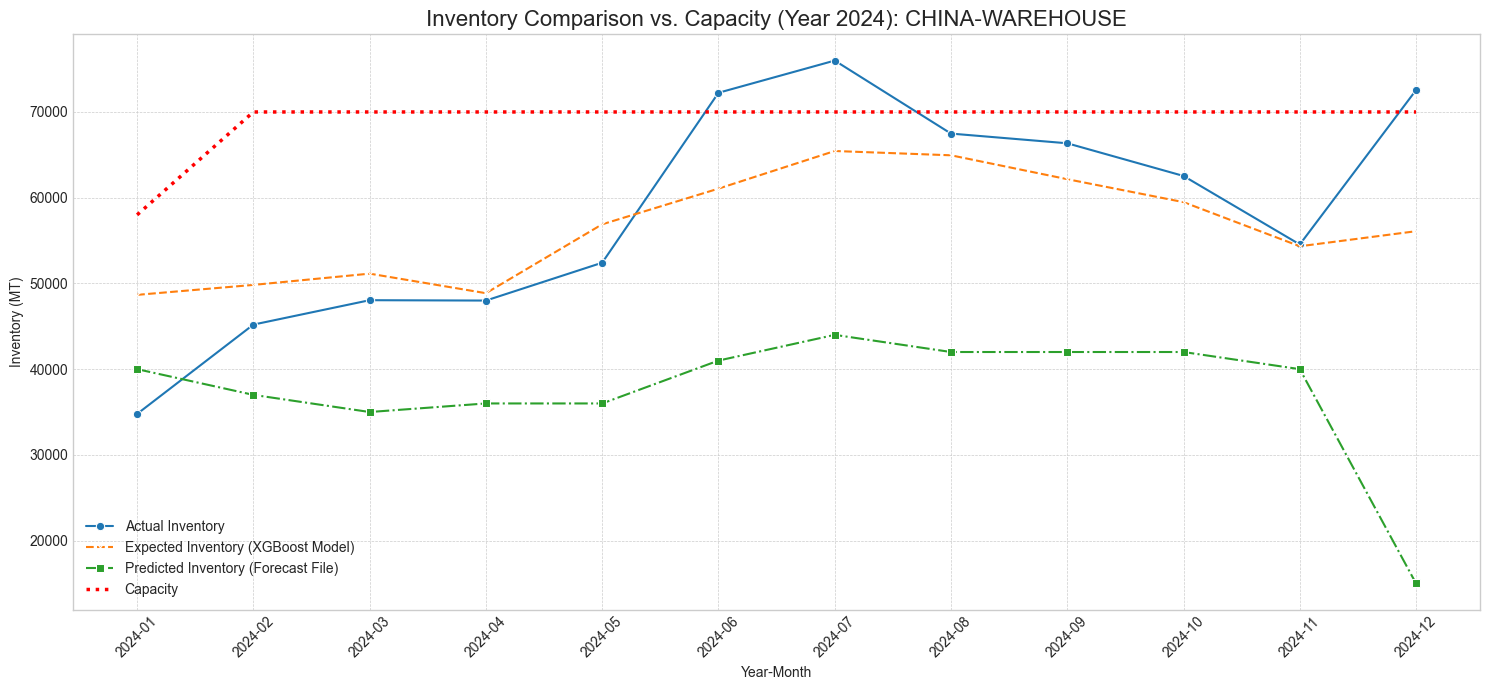

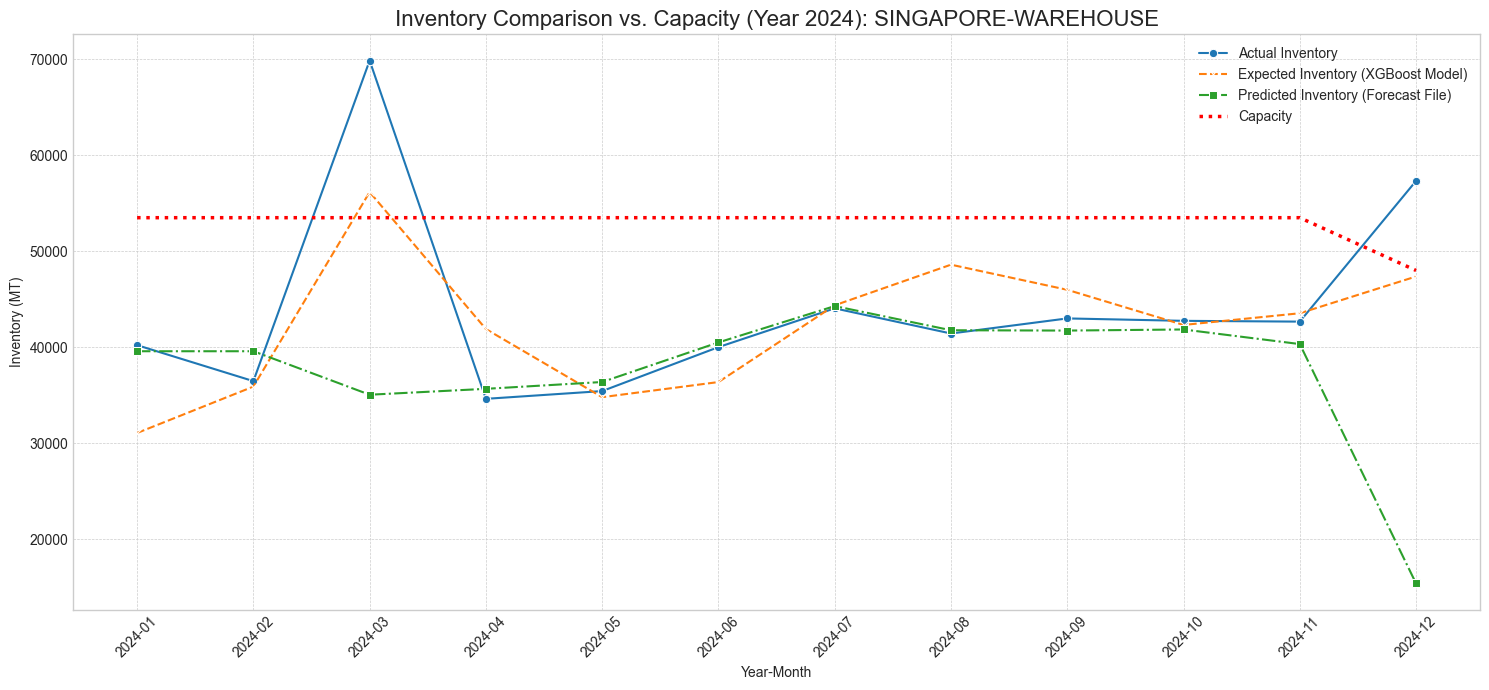

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ดึง df_model ออกมาจากตัวแปร result ที่ได้จากเซลล์ก่อนหน้า
df_model = result['model_df']

# --- เพิ่มส่วนนี้เพื่อกรองข้อมูลเฉพาะปี 2024 ---
df_2024 = df_model[df_model['YEAR_MONTH'].dt.year == 2024].copy()


# เพิ่มคอลัมน์ 'MONTH' และ 'YEAR_MONTH_STR' ใน DataFrame ที่กรองแล้ว
df_2024['MONTH'] = df_2024['YEAR_MONTH'].dt.month
df_2024['YEAR_MONTH_STR'] = df_2024['YEAR_MONTH'].astype(str)


# วนลูปเพื่อพล็อตแต่ละ Plant ในกราฟที่แยกกัน โดยใช้ข้อมูล df_2024
for plant in df_2024['PLANT_NAME'].unique():
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 7))
    
    plant_data = df_2024[df_2024['PLANT_NAME'] == plant].sort_values('YEAR_MONTH')
    
    # สร้างคอลัมน์ CAPACITY_MT
    if plant == 'SINGAPORE-WAREHOUSE':
        plant_data['CAPACITY_MT'] = np.where(plant_data['MONTH'] == 12, 48000, 53500)
    elif plant == 'CHINA-WAREHOUSE':
        plant_data['CAPACITY_MT'] = np.where(plant_data['MONTH'] == 1, 58000, 70000)
    
    
    # พล็อตกราฟเส้น
    sns.lineplot(data=plant_data, x='YEAR_MONTH_STR', y='UNRESTRICTED_ACTUAL_MT', marker='o', linestyle='-', label='Actual Inventory')
    sns.lineplot(data=plant_data, x='YEAR_MONTH_STR', y='EXPECTED_INVENTORY', marker='x', linestyle='--', label='Expected Inventory (XGBoost Model)')
    
    # --- ✨ บรรทัดที่เพิ่มเข้ามาใหม่ ---
    sns.lineplot(data=plant_data, x='YEAR_MONTH_STR', y='PREDICTED_INVENTORY_MT', marker='s', linestyle='-.', label='Predicted Inventory (Forecast File)')
    # ---------------------------------
    
    sns.lineplot(data=plant_data, x='YEAR_MONTH_STR', y='CAPACITY_MT', color='red', linestyle=':', linewidth=2.5, label='Capacity')
    
    # ตกแต่งกราฟ
    plt.title(f'Inventory Comparison vs. Capacity (Year 2024): {plant}', fontsize=16)
    plt.ylabel('Inventory (MT)')
    plt.xlabel('Year-Month')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

**correalation feature  and target**

C:\Users\ppich\AppData\Local\Temp\ipykernel_16724\745141184.py:235: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




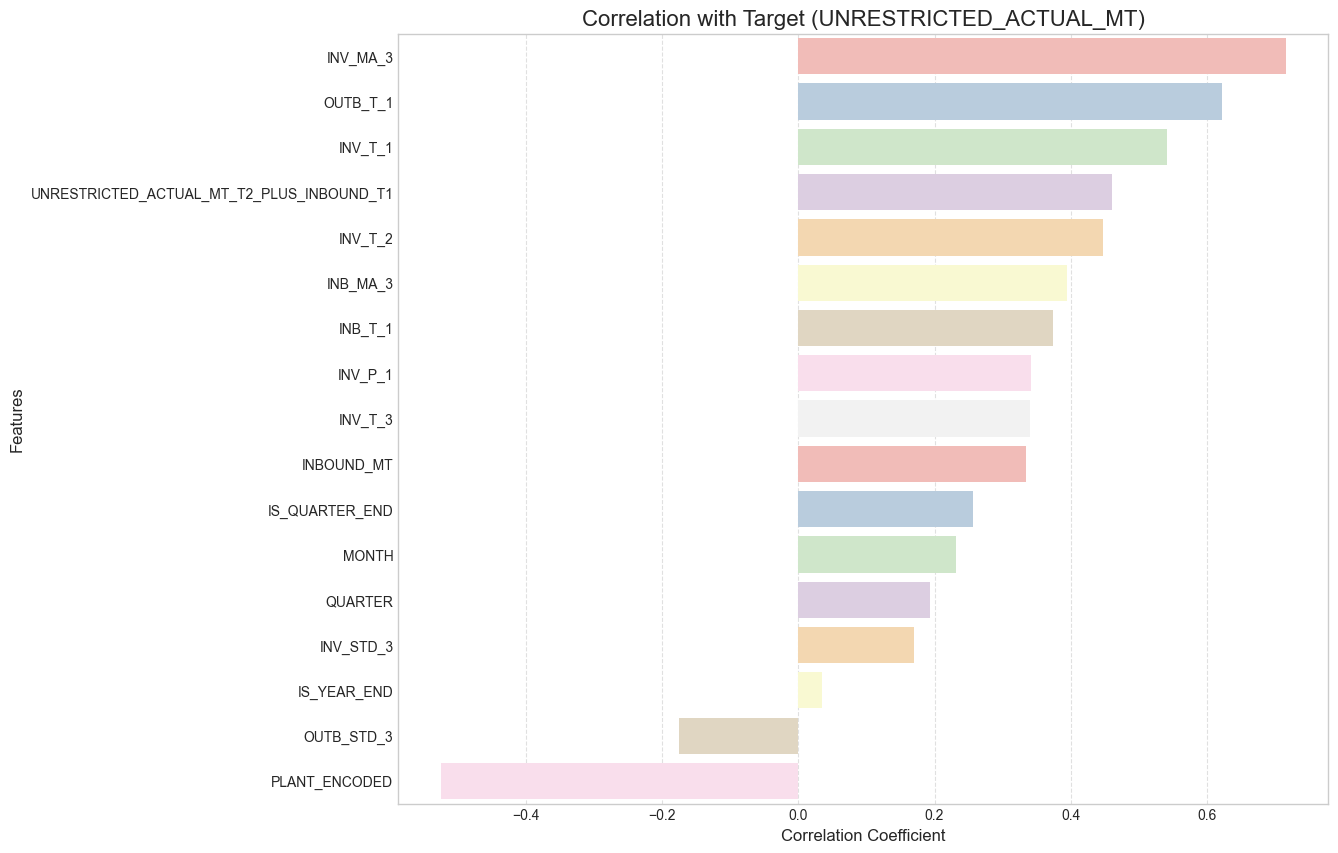

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 


file_path_inbound = os.path.abspath('../data_cleaned/Cleaned_Inbound_sorted.xlsx')
file_path_inventory = os.path.abspath('../data_cleaned/Cleaned_Inventory_sorted.xlsx')
file_path_materialmaster = os.path.abspath('../data_cleaned/Cleaned_material.xlsx')
file_path_outbound = os.path.abspath('../data_cleaned/Cleaned_outbound_sorted.xlsx')

inbound = pd.read_excel(file_path_inbound)
inventory = pd.read_excel(file_path_inventory)
materialmaster = pd.read_excel(file_path_materialmaster)
outbound = pd.read_excel(file_path_outbound)
operationcost = pd.read_excel('../data_cleaned/Cleaned_OperationCost.xlsx')
forecast =  pd.read_excel('../data_cleaned/forecast_1.xlsx')


def normalize(name):
    """Normalize plant names for consistent matching"""
    return name.lower().replace('-', ' ').strip()


capacity_dict = {
    ('SINGAPORE-WAREHOUSE', 1): 53500, ('SINGAPORE-WAREHOUSE', 2): 53500,
    ('SINGAPORE-WAREHOUSE', 3): 53500, ('SINGAPORE-WAREHOUSE', 4): 53500,
    ('SINGAPORE-WAREHOUSE', 5): 53500, ('SINGAPORE-WAREHOUSE', 6): 53500,
    ('SINGAPORE-WAREHOUSE', 7): 53500, ('SINGAPORE-WAREHOUSE', 8): 53500,
    ('SINGAPORE-WAREHOUSE', 9): 53500, ('SINGAPORE-WAREHOUSE', 10): 53500,
    ('SINGAPORE-WAREHOUSE', 11): 53500, ('SINGAPORE-WAREHOUSE', 12): 48000,
    ('CHINA-WAREHOUSE', 1): 58000, ('CHINA-WAREHOUSE', 2): 70000,
    ('CHINA-WAREHOUSE', 3): 70000, ('CHINA-WAREHOUSE', 4): 70000,
    ('CHINA-WAREHOUSE', 5): 70000, ('CHINA-WAREHOUSE', 6): 70000,
    ('CHINA-WAREHOUSE', 7): 70000, ('CHINA-WAREHOUSE', 8): 70000,
    ('CHINA-WAREHOUSE', 9): 70000, ('CHINA-WAREHOUSE', 10): 70000,
    ('CHINA-WAREHOUSE', 11): 70000, ('CHINA-WAREHOUSE', 12): 70000,
}

def get_capacity(row):
    month = row['YEAR_MONTH'].month if isinstance(row['YEAR_MONTH'], pd.Period) else pd.Period(row['YEAR_MONTH']).month
    plant = normalize(row['PLANT_NAME'])
    normalized_dict = {(normalize(k[0]), k[1]): v for k, v in capacity_dict.items()}
    return normalized_dict.get((plant, month), np.nan)

def prepare_data_for_analysis(inventory_df, outbound_df, inbound_df, forecast_df):
    """Prepare merged data for overflow analysis"""
    df = inventory_df.copy()
    df['BALANCE_AS_OF_DATE'] = pd.to_datetime(df['BALANCE_AS_OF_DATE'])
    df['YEAR_MONTH'] = df['BALANCE_AS_OF_DATE'].dt.to_period('M')
    
    outbound_agg = outbound_df.copy()
    outbound_agg['OUTBOUND_DATE'] = pd.to_datetime(outbound_agg['OUTBOUND_DATE'])
    outbound_agg['YEAR_MONTH'] = outbound_agg['OUTBOUND_DATE'].dt.to_period('M')
    outbound_summary = outbound_agg.groupby(['PLANT_NAME', 'YEAR_MONTH'])['NET_QUANTITY_MT'].sum().reset_index()
    outbound_summary = outbound_summary.rename(columns={'NET_QUANTITY_MT': 'PREDICTED_OUTBOUND_MT'})
    
    inbound_agg = inbound_df.copy()
    inbound_agg['INBOUND_DATE'] = pd.to_datetime(inbound_agg['INBOUND_DATE'])
    inbound_agg['YEAR_MONTH'] = inbound_agg['INBOUND_DATE'].dt.to_period('M')
    monthly_inbound = inbound_agg.groupby(['YEAR_MONTH', 'PLANT_NAME'])['NET_QUANTITY_MT'].sum().reset_index()
    monthly_inbound.rename(columns={'NET_QUANTITY_MT': 'INBOUND_MT'}, inplace=True)
    
    inventory_summary = df.groupby(['PLANT_NAME', 'YEAR_MONTH'])['UNRESTRICTED_STOCK_MT'].sum().reset_index()
    inventory_summary = inventory_summary.rename(columns={'UNRESTRICTED_STOCK_MT': 'UNRESTRICTED_ACTUAL_MT'})
    
    forecast_use = forecast_df.copy()
    plant_map = { 'sg': 'SINGAPORE-WAREHOUSE', 'cn': 'CHINA-WAREHOUSE' }
    forecast_use['Date'] = pd.to_datetime(forecast_use['Date'])
    forecast_use['YEAR_MONTH'] = forecast_use['Date'].dt.to_period('M')
    forecast_use['PLANT_NAME'] = forecast_use['Warehouse'].str.lower().map(plant_map)
    forecast_summary = forecast_use.rename(columns={'Predicted Inventory (MT)': 'PREDICTED_INVENTORY_MT'})
    
    merged_df = inventory_summary.merge(monthly_inbound, on=['YEAR_MONTH', 'PLANT_NAME'], how='left') \
                                 .merge(outbound_summary, on=['PLANT_NAME', 'YEAR_MONTH'], how='left') \
                                 .merge(forecast_summary[['PLANT_NAME', 'YEAR_MONTH', 'PREDICTED_INVENTORY_MT']], 
                                        on=['PLANT_NAME', 'YEAR_MONTH'], 
                                        how='left')
    
    merged_df['INBOUND_MT'] = merged_df['INBOUND_MT'].fillna(0)
    merged_df['PREDICTED_OUTBOUND_MT'] = merged_df['PREDICTED_OUTBOUND_MT'].fillna(0)
    merged_df['PREDICTED_INVENTORY_MT'] = merged_df['PREDICTED_INVENTORY_MT'].fillna(0)
    
    return merged_df


def analyze_overflow_with_xgb_improved(df, target_year, target_month):
    df = df.copy()
    df['YEAR_MONTH'] = df['YEAR_MONTH'].apply(lambda x: pd.Period(x, freq='M') if not isinstance(x, pd.Period) else x)
    df = df.sort_values(['PLANT_NAME', 'YEAR_MONTH']).reset_index(drop=True)
    df['PLANT_ENCODED'] = df['PLANT_NAME'].astype('category').cat.codes
    df['MONTH'] = df['YEAR_MONTH'].dt.month
    df['QUARTER'] = df['YEAR_MONTH'].dt.quarter
    df['IS_YEAR_END'] = (df['MONTH'] == 12).astype(int)
    df['IS_QUARTER_END'] = df['MONTH'].isin([3, 6, 9, 12]).astype(int)

    
    df['INV_T_1'] = np.nan
    df['INV_T_2'] = np.nan
    df['INV_T_3'] = np.nan
    df['INB_T_1'] = np.nan
    df['OUTB_T_1'] = np.nan
    df['INV_P_1'] = np.nan
    df['INV_MA_3'] = np.nan
    df['INB_MA_3'] = np.nan
    df['OUTB_MA_3'] = np.nan
    df['INV_STD_3'] = np.nan
    df['OUTB_STD_3'] = np.nan

    for plant in df['PLANT_NAME'].unique():
        mask = df['PLANT_NAME'] == plant
        plant_data = df.loc[mask].sort_values('YEAR_MONTH')
        df.loc[mask, 'INV_T_1'] = plant_data['UNRESTRICTED_ACTUAL_MT'].shift(1)
        df.loc[mask, 'INV_T_2'] = plant_data['UNRESTRICTED_ACTUAL_MT'].shift(2)
        df.loc[mask, 'INV_T_3'] = plant_data['UNRESTRICTED_ACTUAL_MT'].shift(3)
        df.loc[mask, 'INB_T_1'] = plant_data['INBOUND_MT'].shift(1)
        df.loc[mask, 'OUTB_T_1'] = plant_data['PREDICTED_OUTBOUND_MT'].shift(1)
        df.loc[mask, 'INV_P_1'] = plant_data['PREDICTED_INVENTORY_MT'].shift(1)
        df.loc[mask, 'INV_MA_3'] = plant_data['UNRESTRICTED_ACTUAL_MT'].rolling(3).mean()
        df.loc[mask, 'INB_MA_3'] = plant_data['INBOUND_MT'].rolling(3).mean()
        df.loc[mask, 'OUTB_MA_3'] = plant_data['PREDICTED_OUTBOUND_MT'].rolling(3).mean()
        df.loc[mask, 'INV_STD_3'] = plant_data['UNRESTRICTED_ACTUAL_MT'].rolling(3).std()
        df.loc[mask, 'OUTB_STD_3'] = plant_data['PREDICTED_OUTBOUND_MT'].rolling(3).std()

    df['YEAR_MONTH_T_MINUS_1'] = df['YEAR_MONTH'] - 1
    df['YEAR_MONTH_T_MINUS_2'] = df['YEAR_MONTH'] - 2
    df_lag1 = df[['PLANT_NAME', 'YEAR_MONTH', 'INBOUND_MT']].rename(
        columns={'YEAR_MONTH': 'YEAR_MONTH_T_MINUS_1', 'INBOUND_MT': 'INBOUND_MT_LAG1'}
    )
    df_lag2 = df[['PLANT_NAME', 'YEAR_MONTH', 'UNRESTRICTED_ACTUAL_MT']].rename(
        columns={'YEAR_MONTH': 'YEAR_MONTH_T_MINUS_2', 'UNRESTRICTED_ACTUAL_MT': 'INV_LAG2'}
    )
    df = df.merge(df_lag1, on=['PLANT_NAME', 'YEAR_MONTH_T_MINUS_1'], how='left')
    df = df.merge(df_lag2, on=['PLANT_NAME', 'YEAR_MONTH_T_MINUS_2'], how='left')
    df['UNRESTRICTED_ACTUAL_MT_T2_PLUS_INBOUND_T1'] = df['INBOUND_MT_LAG1'] + df['INV_LAG2']

    lag_features = ['INV_T_1', 'INV_T_2', 'INV_T_3', 'INB_T_1', 'OUTB_T_1', 'INV_P_1',
                    'INV_MA_3', 'INB_MA_3', 'OUTB_MA_3', 'UNRESTRICTED_ACTUAL_MT_T2_PLUS_INBOUND_T1','INV_STD_3', 'OUTB_STD_3']
    for plant in df['PLANT_NAME'].unique():
        mask = df['PLANT_NAME'] == plant
        for f in lag_features:
            df.loc[mask, f] = df.loc[mask, f].fillna(df.loc[mask, f].mean(skipna=True)) # Corrected line

    df_model = df.copy()
    df_model = df_model.sort_values('YEAR_MONTH')
    train_size = int(len(df_model) * 0.8)
    train_df = df_model.iloc[:train_size]
    test_df = df_model.iloc[train_size:]
    
   
    global features, model 
    features = ['INV_T_1', 'INV_T_2', 'INV_T_3', 'INB_T_1', 'OUTB_T_1', 'INBOUND_MT',
                'QUARTER', 'MONTH', 'INV_P_1', 'INV_MA_3', 'UNRESTRICTED_ACTUAL_MT_T2_PLUS_INBOUND_T1',
                'INB_MA_3', 'PLANT_ENCODED', 'IS_YEAR_END', 'IS_QUARTER_END','INV_STD_3', 'OUTB_STD_3']

    target = 'UNRESTRICTED_ACTUAL_MT'

    X_train = train_df[features]
    y_train = train_df[target]
    X_test = test_df[features]
    y_test = test_df[target]

    import xgboost as xgb 
    best_params = {
        'max_depth': 8,
        'learning_rate': 0.16438179870311287,
        'subsample': 0.7008753114485383,
        'colsample_bytree': 0.5553690914236263,
        'reg_alpha': 0.2,
        'reg_lambda': 0.1,
        'min_child_weight': 8,
        'gamma': 4.266195291786033,
    }

    model = xgb.XGBRegressor(
        n_estimators=100,
        **best_params,
        random_state=42,
    )

    model.fit(X_train, y_train)

    from sklearn.metrics import mean_absolute_error 
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    df_model['EXPECTED_INVENTORY'] = model.predict(df_model[features])
    df = df.merge(df_model[['YEAR_MONTH', 'PLANT_NAME', 'EXPECTED_INVENTORY']], on=['YEAR_MONTH', 'PLANT_NAME'], how='left')
    df['EXPECTED_INVENTORY'] = df['EXPECTED_INVENTORY'].fillna(df['PREDICTED_INVENTORY_MT'])

    df['CAPACITY_MT'] = df.apply(get_capacity, axis=1)
    df['UTILIZATION_RATE'] = df['EXPECTED_INVENTORY'] / df['CAPACITY_MT']
    
    def risk_level(rate):
        if pd.isna(rate): return 'Insufficient Data'
        elif rate >= 1.0: return 'OVERFLOW'
        elif rate >= 0.90: return 'CRITICAL'
        elif rate > 0.80: return 'HIGH'
        elif 0.70 <= rate <= 0.80: return 'NORMAL'
        else: return 'LOW'
    
    df['RISK_LEVEL'] = df['UTILIZATION_RATE'].apply(risk_level)
    df['TOTAL_STOCK_AFTER_INBOUND'] = df['UNRESTRICTED_ACTUAL_MT'] + df['INBOUND_MT']
    df['IS_OVERFLOW'] = df['EXPECTED_INVENTORY'] > df['CAPACITY_MT']
    
    target_period = pd.Period(f"{target_year}-{target_month:02d}", freq='M')
    result = df[df['YEAR_MONTH'] == target_period].copy()
    
    return result, df_model
    

merged_df = prepare_data_for_analysis(inventory, outbound, inbound, forecast)
result_analysis, df_model = analyze_overflow_with_xgb_improved(merged_df, 2024, 3)


if 'df_model' in globals() and 'features' in globals():
    
    if all(col in df_model.columns for col in features + ['UNRESTRICTED_ACTUAL_MT']):
        
        data_for_corr = df_model[features + ['UNRESTRICTED_ACTUAL_MT']]
        corr_matrix = data_for_corr.corr()

        
        corr_with_target = corr_matrix['UNRESTRICTED_ACTUAL_MT']

        
        sorted_corr = corr_with_target.drop('UNRESTRICTED_ACTUAL_MT').sort_values(ascending=False)

        
        plt.figure(figsize=(12, 10))
        
        sns.barplot(x=sorted_corr.values, y=sorted_corr.index, palette='Pastel1') 

        
        plt.title('Correlation with Target (UNRESTRICTED_ACTUAL_MT)', fontsize=16)
        plt.xlabel('Correlation Coefficient', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.show()

        
    else:
        print("❌ ข้อผิดพลาด: df_model ไม่มีคอลัมน์ที่จำเป็นสำหรับการคำนวณ Correlation")
        print("ตรวจสอบว่า 'UNRESTRICTED_ACTUAL_MT' และฟีเจอร์ทั้งหมดใน 'features' อยู่ใน df_model")
else:
    print("❌ ข้อผิดพลาด: ตัวแปร 'df_model' หรือ 'features' ยังไม่ได้ถูกกำหนดในขอบเขตที่เข้าถึงได้")
    print("โปรดตรวจสอบให้แน่ใจว่าได้รันฟังก์ชัน analyze_overflow_with_xgb_improved หรือฟังก์ชันที่เกี่ยวข้องแล้ว")